# **`Vison Transformer`**

## 1. [Vision Transformer](https://analyticsindiamag.com/complete-guide-to-t2t-vit-training-vision-transformers-efficiently-with-minimal-data/)
## 2. [What Are Vision Transformers And How Are They Important For General Purpose Learning?](https://towardsdatascience.com/what-are-vision-transformers-and-how-are-they-important-for-general-purpose-learning-edd008545e9e)
## 3. Image Captioning
## **Text Transformers**
![](https://miro.medium.com/max/875/1*prnQfLgRAanmt2jm0F8dxg.png)

## 4. **Vision Transformers**
![](https://miro.medium.com/max/875/1*_c8SqxPMY_dsApyvDJ8HtA.gif)

## 5. [Demo](https://github.com/azad-academy/vision-transformers/blob/main/vision-transformers-demo.ipynb)
## 6. [Object Detection](https://medium.com/nerd-for-tech/vision-transformers-use-case-satellite-image-classification-without-cnns-2c4dbeb06f87)
## 7. [Vit from Scratch](https://www.kaggle.com/code/raufmomin/vision-transformer-vit-from-scratch)
## 8. [VITs in 10 min](https://theaisummer.com/vision-transformer/)
## 9. [Object Detection with Transformers Research Paper](https://arxiv.org/pdf/2005.12872.pdf)
## 10. [MS Lesion detection](https://www.kaggle.com/code/marwa96/isbi-dataset-ms-lesion-segmentation)

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 36.5 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()
warnings.filterwarnings('ignore')

TensorFlow Version 2.8.2


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.75G/5.76G [02:20<00:00, 35.5MB/s]
100% 5.76G/5.76G [02:20<00:00, 44.0MB/s]


In [ ]:
!unzip /content/cassava-leaf-disease-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/3954487465.jpg  
  inflating: train_images/3954910918.jpg  
  inflating: train_images/3955391972.jpg  
  inflating: train_images/3955442838.jpg  
  inflating: train_images/3955739563.jpg  
  inflating: train_images/3955931830.jpg  
  inflating: train_images/3955972139.jpg  
  inflating: train_images/3956075690.jpg  
  inflating: train_images/3956077728.jpg  
  inflating: train_images/3956155774.jpg  
  inflating: train_images/3956271103.jpg  
  inflating: train_images/3956372146.jpg  
  inflating: train_images/3956407201.jpg  
  inflating: train_images/3956550570.jpg  
  inflating: train_images/3956605397.jpg  
  inflating: train_images/3956778160.jpg  
  inflating: train_images/3957562076.jpg  
  inflating: train_images/3957612771.jpg  
  inflating: train_images/3957807023.jpg  
  inflating: train_images/3957819631.jpg  
  inflating: train_images/395820132.jpg  
  inflating: train_images/3958304403.jpg  
  in

In [ ]:
image_size = 224
batch_size = 16
n_classes = 5

TRAIN_PATH = '/content/train_images'
TEST_PATH = '/content/test_images'

df_train = pd.read_csv('/content/train.csv', dtype='str')
test_images = glob.glob(TEST_PATH + '/*.jpg')
df_test = pd.DataFrame(test_images, columns = ['image_path'])

classes = {0 : "Cassava Bacterial Blight (CBB)",
           1 : "Cassava Brown Streak Disease (CBSD)",
           2 : "Cassava Green Mottle (CGM)",
           3 : "Cassava Mosaic Disease (CMD)",
           4 : "Healthy"}

In [ ]:
df_train.head()

image_id label
0  1000015157.jpg     0
1  1000201771.jpg     3
2   100042118.jpg     1
3  1000723321.jpg     1
4  1000812911.jpg     3

In [ ]:
df_test.head()

image_path
0  /content/test_images/2216849948.jpg

## Data Augmentation

In [ ]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
 
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    return image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Data Generator

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.2,
                                                          preprocessing_function = data_augment)

train_gen = datagen.flow_from_dataframe(dataframe = df_train,
                                        directory = TRAIN_PATH,
                                        x_col = 'image_id',
                                        y_col = 'label',
                                        subset = 'training',
                                        batch_size = batch_size,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (image_size, image_size))

valid_gen = datagen.flow_from_dataframe(dataframe = df_train,
                                        directory = TRAIN_PATH,
                                        x_col = 'image_id',
                                        y_col = 'label',
                                        subset = 'validation',
                                        batch_size = batch_size,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = False,
                                        class_mode = 'categorical',
                                        target_size = (image_size, image_size))

test_gen = datagen.flow_from_dataframe(dataframe = df_test,
                                       x_col = 'image_path',
                                       y_col = None,
                                       batch_size = batch_size,
                                       seed = 1,
                                       color_mode = 'rgb',
                                       shuffle = False,
                                       class_mode = None,
                                       target_size = (image_size, image_size))

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.
Found 1 validated image filenames.


## Sample Image Visualization

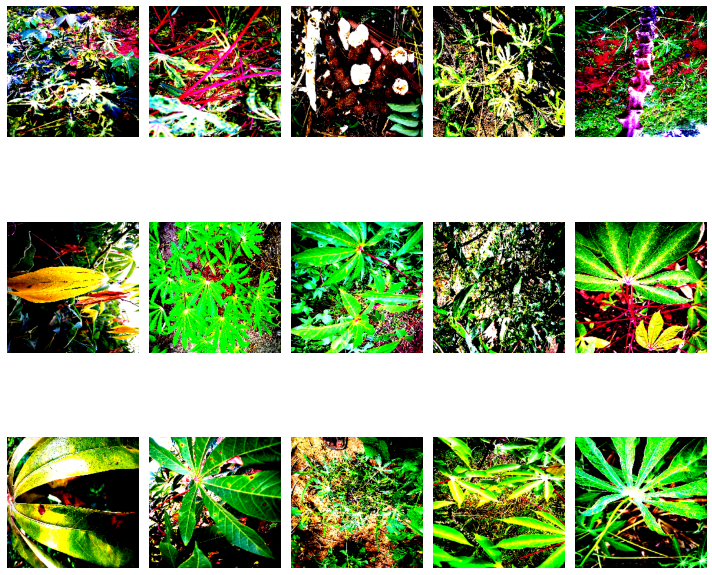

In [ ]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(image_size, image_size, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

## Model Hyperparameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 1

patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [56, 28]  # Size of the dense layers of the final classifier

# Building the Model and it's Components
## 1. Multilayer Perceptron (MLP)
- The MLP is a two-layer classification network with GELU (Gaussian Error Linear Unit) at the end. The final MLP block, also termed as MLP head is used as an output of the transformer. An application of softmax on this output can provide classification labels (i.e. if the application is Image Classification).

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = L.Dense(units, activation = tf.nn.gelu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

## 2. Patch Creation Layer

In [ ]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

## Sample Image Patch Visualization

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


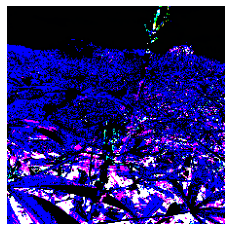

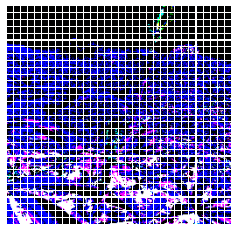

In [ ]:
plt.figure(figsize=(4, 4))

x = train_gen.next()
image = x[0][0]

plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

## 3. Patch Encoding Layer
- The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [ ]:
class PatchEncoder(L.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = L.Dense(units = projection_dim)
        self.position_embedding = L.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )

    def call(self, patch):
        positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Build the ViT model
- The ViT model consists of multiple Transformer blocks, which use the MultiHeadAttention layer as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a [batch_size, num_patches, projection_dim] tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.

- Unlike the technique described in the paper, which prepends a learnable embedding to the sequence of encoded patches to serve as the image representation, all the outputs of the final Transformer block are reshaped with Flatten() and used as the image representation input to the classifier head. Note that the GlobalAveragePooling1D layer could also be used instead to aggregate the outputs of the Transformer block, especially when the number of patches and the projection dimensions are large.

In [ ]:
def vision_transformer():
    inputs = L.Input(shape = (image_size, image_size, 3))
    
    # Create patches.
    patches = Patches(patch_size)(inputs)
    
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        
        # Layer normalization 1.
        x1 = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        
        # Create a multi-head attention layer.
        attention_output = L.MultiHeadAttention(
            num_heads = num_heads, key_dim = projection_dim, dropout = 0.1
        )(x1, x1)
        
        # Skip connection 1.
        x2 = L.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2.
        x3 = L.LayerNormalization(epsilon = 1e-6)(x2)
        
        # MLP.
        x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)
        
        # Skip connection 2.
        encoded_patches = L.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = L.Flatten()(representation)
    representation = L.Dropout(0.5)(representation)
    
    # Add MLP.
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)
    
    # Classify outputs.
    logits = L.Dense(n_classes)(features)
    
    # Create the model.
    model = tf.keras.Model(inputs = inputs, outputs = logits)
    
    return model

In [ ]:
decay_steps = train_gen.n // train_gen.batch_size
initial_learning_rate = learning_rate

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, decay_steps)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model = vision_transformer()
    
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
              metrics = ['accuracy'])


STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, lr_scheduler, checkpointer]

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = num_epochs,
          callbacks = callbacks)

 141/1069 [==>...........................] - ETA: 6:32:40 - loss: 6.6068 - accuracy: 0.3989

# Vit model for MS Detection
## Explore nii photos

In [ ]:
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def display(path,label,num,x,y):
  img = nib.load(path).get_fdata()
  print('Shape of Image =>',img.shape)
  print(label)
  for i in range(num):
      plt.subplot(x,y,i + 1)
      plt.imshow(img[:,:,1 + i])
      plt.gcf().set_size_inches(10, 10)
  
  plt.show()

Shape of Image => (256, 256, 23)
Flair Image


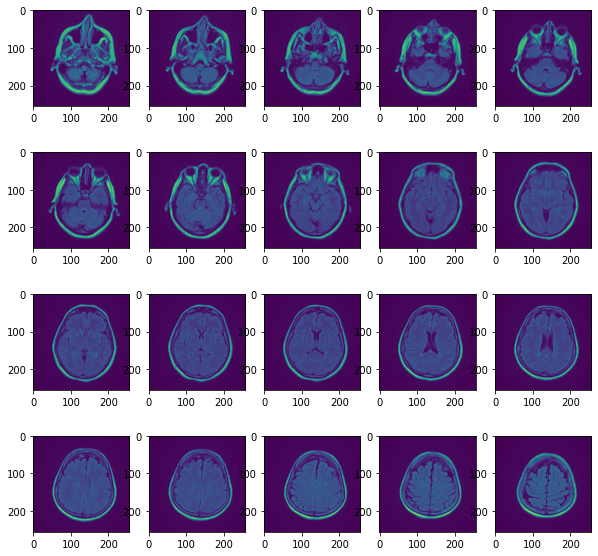

In [ ]:
display('/content/1-Flair.nii','Flair Image',20,4,5)

Shape of Image => (256, 256, 19)
T2


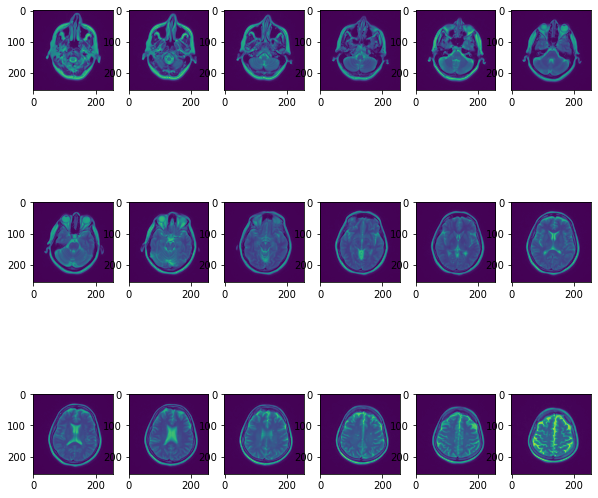

In [ ]:
display('/content/1-T2.nii','T2',18,3,6)

Shape of Image => (512, 512, 19)
T1


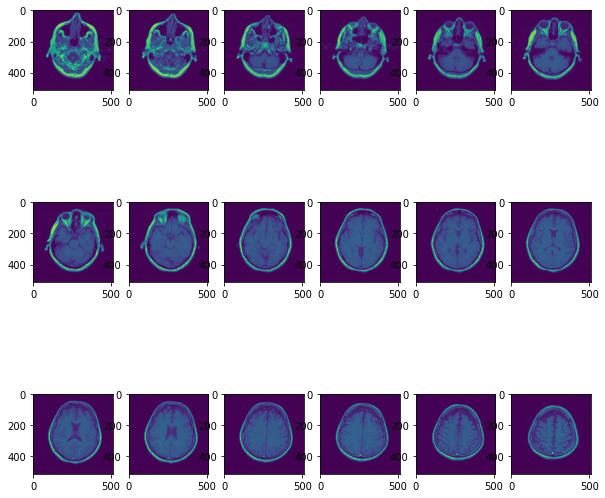

In [ ]:
display('/content/1-T1.nii','T1',18,3,6)

Shape of Image => (256, 256, 23)
LesionSeg-Flair


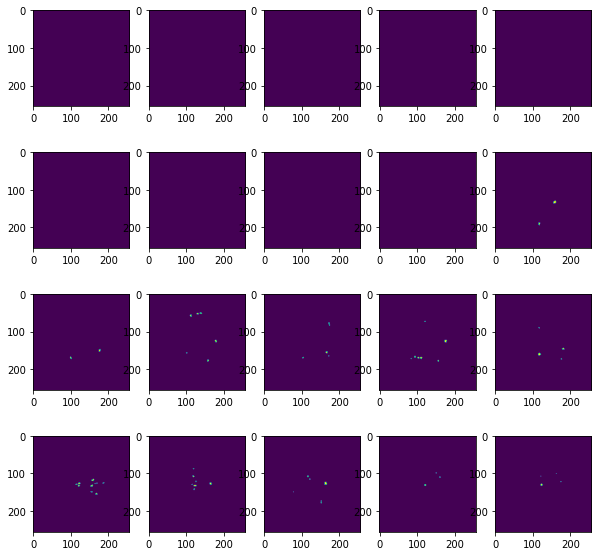

In [ ]:
display('/content/1-LesionSeg-Flair.nii','LesionSeg-Flair',20,4,5)

Shape of Image => (512, 512, 19)
Seg-T1


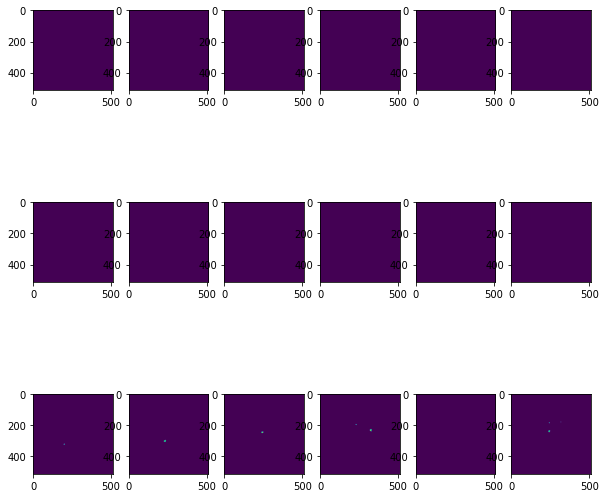

In [ ]:
display('/content/1-LesionSeg-T1.nii','Seg-T1',18,3,6)

Shape of Image => (256, 256, 19)
Seg-T2


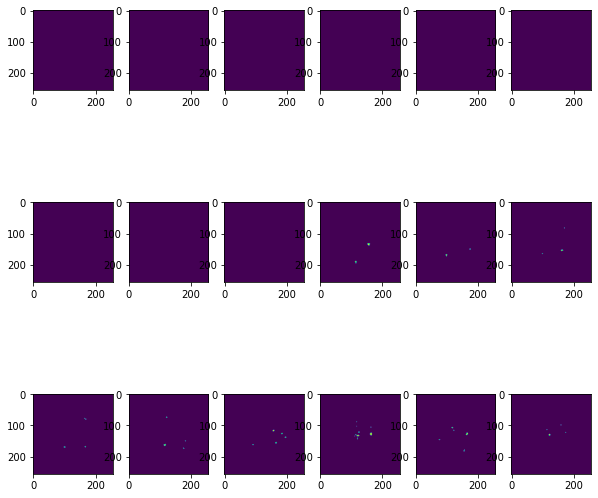

In [ ]:
display('/content/1-LesionSeg-T2.nii','Seg-T2',18,3,6)

# `MS Detection through wavelet transformations`

In [ ]:
!pip install Pillow Mat4py matplotlib scikit-learn Numpy PyWavelets torch --quiet

In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
import os
import PIL.Image
from mat4py import loadmat
import PIL
import matplotlib.pyplot as plt
from sklearn import covariance
import sklearn
import numpy as np
import pywt
import statistics
import torch
import tensorflow as tf

In [ ]:
from mswavelet import MSWavelet

In [ ]:
# cd /content/drive/MyDrive

In [ ]:
rootdir = "/content/drive/MyDrive/MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset"
print("Rootdir", "exists: \""+rootdir+"\"" if os.path.exists(path=rootdir) else "does not exist.")

Rootdir exists: "/content/drive/MyDrive/MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset"


In [ ]:
msw = MSWavelet()
msw.printinfo()

MSWavelet arrays: 
Number of MRI scans:  740
Number of unhealthy MRI scans:  256
Number of healthy MRI scans:  484

Discrete Wavelets list:  ['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 

In [ ]:
# Batch Upsampling
print("Batch Upsampling:")
imgnames = msw.unhealthy_images[:20]
imgfiles = []
for imgname in imgnames:
    imgfile = PIL.Image.open(msw.tif_filename(imgname))
    imgfilenumpy = np.asarray(imgfile)
    if imgfilenumpy.shape[0] == 512:
        imgfiles.append(imgfilenumpy)
imgups = msw.upsample(imgfiles, size=1024)
print("Upscale images array: ", imgups.shape)

Batch Upsampling:
Upsampled shape:  (20, 1024, 1024) Original type:  <class 'numpy.uint8'>
Upscale images array:  (20, 1024, 1024)


In [ ]:
# Batch Wavelet Transforms
img, coeffs_dwt2 = pywt.dwt2(imgups, wavelet="bior6.8")
print("Batch DWT2D array shape: ", np.asarray(coeffs_dwt2).shape)
coeffs_cwt, freqs = pywt.cwt(imgups, wavelet="mexh", scales=np.arange(1,8,2))
print("Batch CWT array shape: ", np.asarray(coeffs_cwt).shape)

Batch DWT2D array shape:  (3, 20, 520, 520)
Batch CWT array shape:  (4, 20, 1024, 1024)


In [ ]:
# Type of cells in Wavelet Transforms
print("What type are the results of wavelet transform?")
print("CWT snippet: ", type(coeffs_cwt[0][0][0][30]), coeffs_cwt[0][0][0][30:33])
print("DWT2D snippet: ", type(coeffs_dwt2[0][0][0][30]), coeffs_dwt2[0][0][0][30:33])
# Free memory
coeffs_dwt2, coeffs_cwt = [], []

What type are the results of wavelet transform?
CWT snippet:  <class 'numpy.float64'> [-0. -0. -0.]
DWT2D snippet:  <class 'numpy.float64'> [0. 0. 0.]



UPSAMPLED IMAGE:

Upsampled shape:  (1024, 1024) Original type:  <class 'numpy.uint8'>


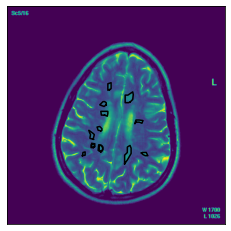

Newimg:  (1024, 1024)

 MEXH CONTINUOUS TRANSFORM

Plaque files for image:  ['./MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_1.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_2.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_3.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_4.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_5.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_6.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_7.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_8.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_9.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_10.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_11.plq', './MRIFreeDataset/Initial & re

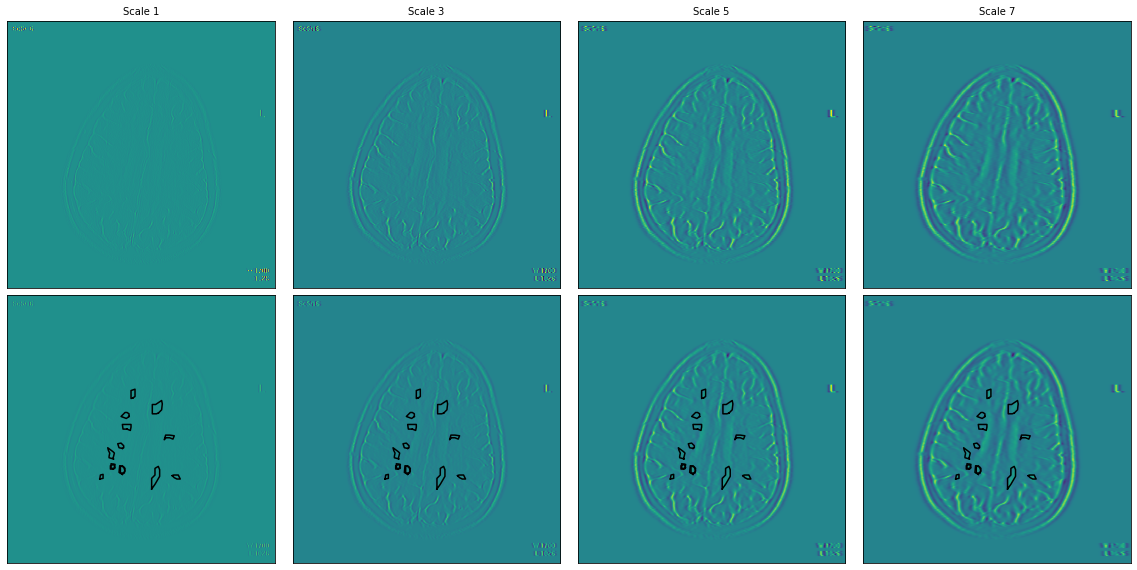


 FBSP CONTINUOUS TRANSFORM



/usr/local/lib/python3.7/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/content/drive/MyDrive/mswavelet.py:279: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs2 = np.array(coeffs2, dtype=self.WT_DTYPE)


Plaque files for image:  ['./MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_1.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_2.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_3.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_4.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_5.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_6.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_7.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_8.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_9.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_10.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_11.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_12.plq',

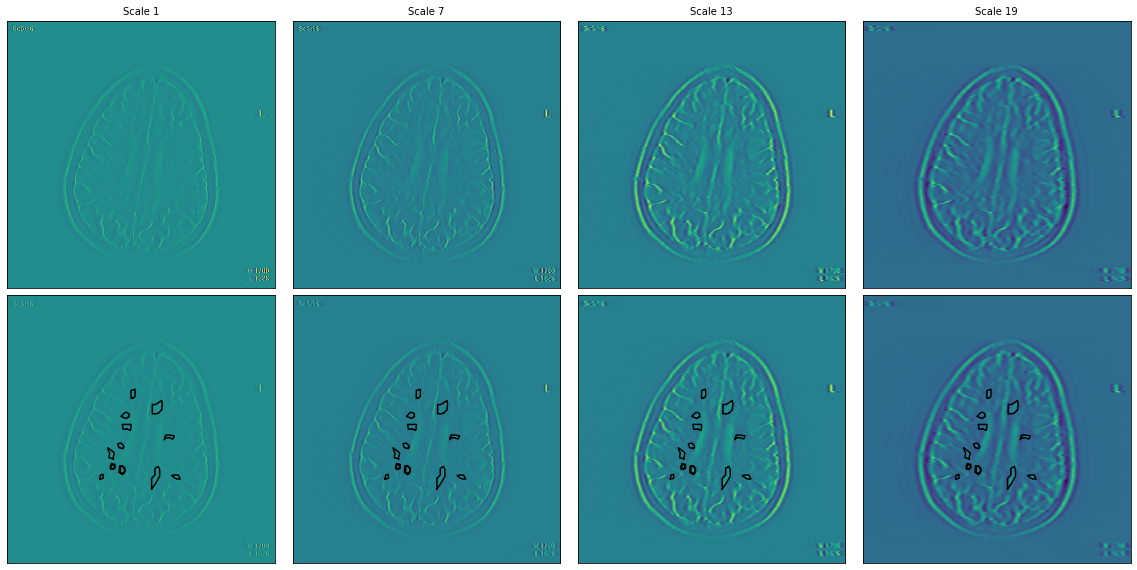


 CGAU4 CONTINUOUS TRANSFORM



/content/drive/MyDrive/mswavelet.py:279: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs2 = np.array(coeffs2, dtype=self.WT_DTYPE)


Plaque files for image:  ['./MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_1.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_2.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_3.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_4.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_5.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_6.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_7.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_8.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_9.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_10.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_11.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_12.plq',

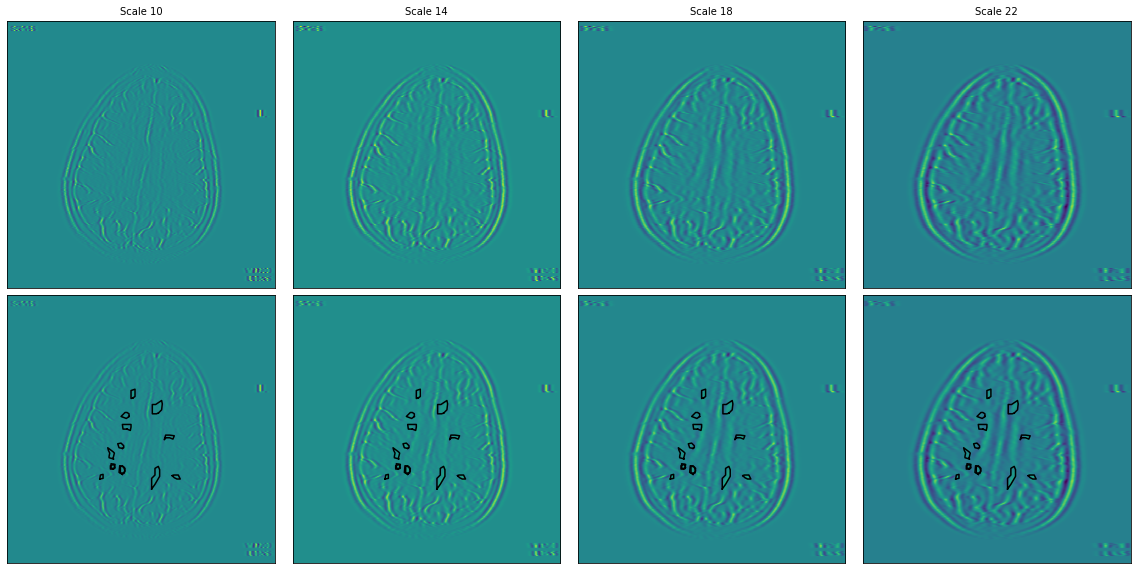


 CGAU8 CONTINUOUS TRANSFORM



/content/drive/MyDrive/mswavelet.py:279: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs2 = np.array(coeffs2, dtype=self.WT_DTYPE)


Plaque files for image:  ['./MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_1.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_2.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_3.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_4.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_5.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_6.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_7.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_8.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_9.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_10.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_11.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_12.plq',

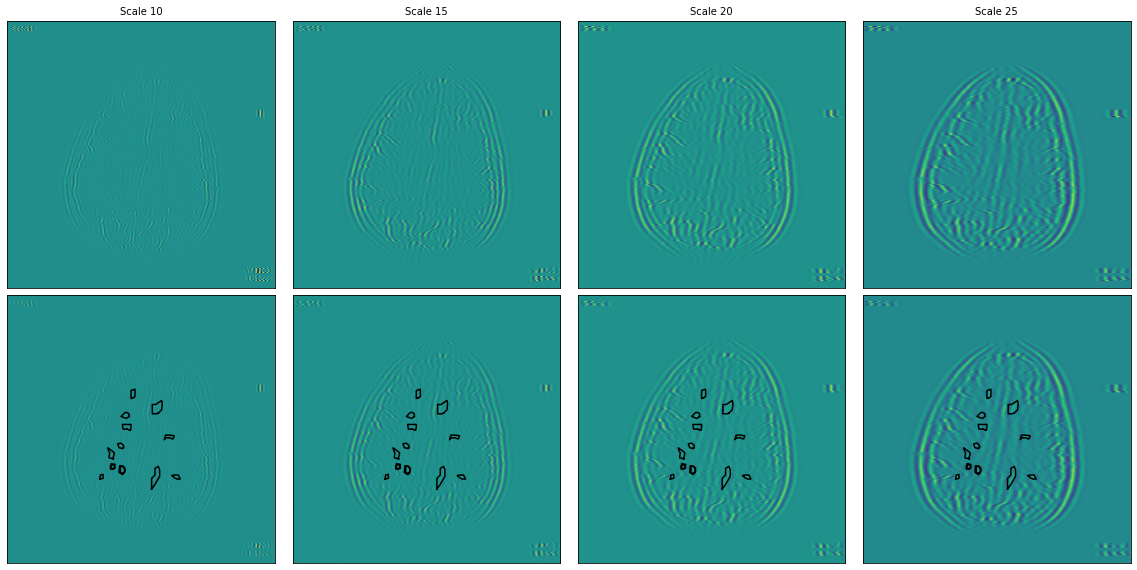


 MORL CONTINUOUS TRANSFORM

Plaque files for image:  ['./MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_1.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_2.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_3.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_4.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_5.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_6.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_7.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_8.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_9.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_10.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_11.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Da

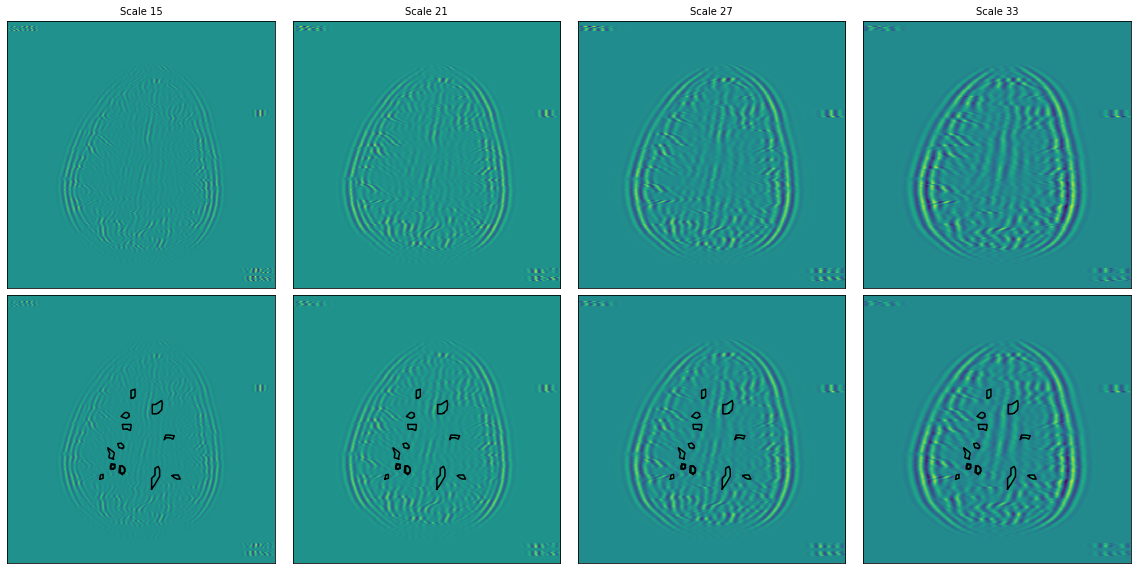


 GAUS4 CONTINUOUS TRANSFORM

Plaque files for image:  ['./MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_1.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_2.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_3.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_4.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_5.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_6.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_7.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_8.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_9.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_10.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_11.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free D

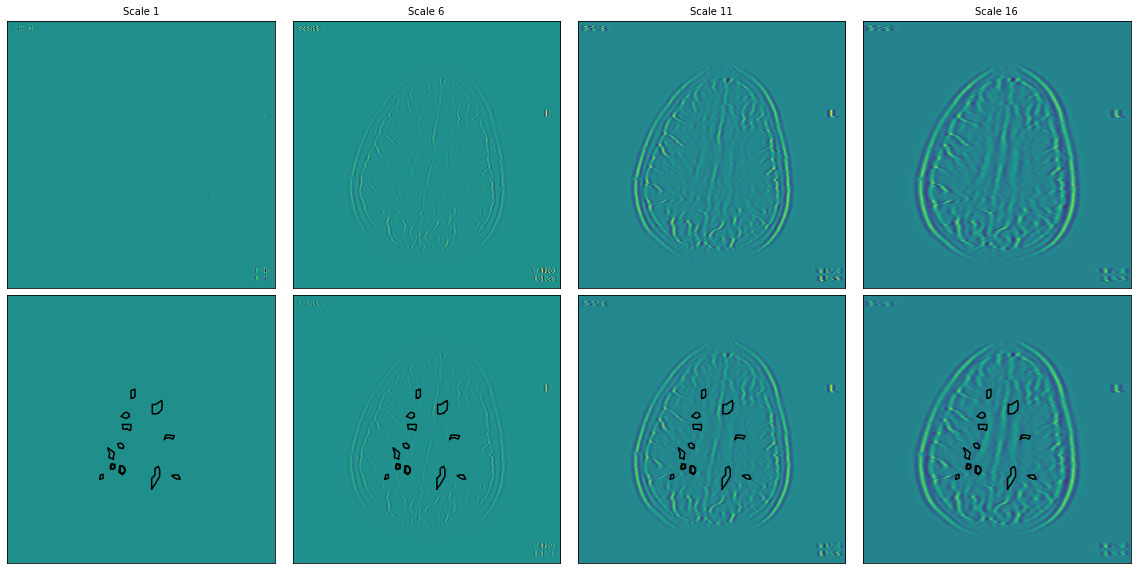


 CMOR CONTINUOUS TRANSFORM



/usr/local/lib/python3.7/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/content/drive/MyDrive/mswavelet.py:279: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs2 = np.array(coeffs2, dtype=self.WT_DTYPE)


Plaque files for image:  ['./MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_1.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_2.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_3.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_4.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_5.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_6.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_7.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_8.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_9.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_10.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_11.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_12.plq',

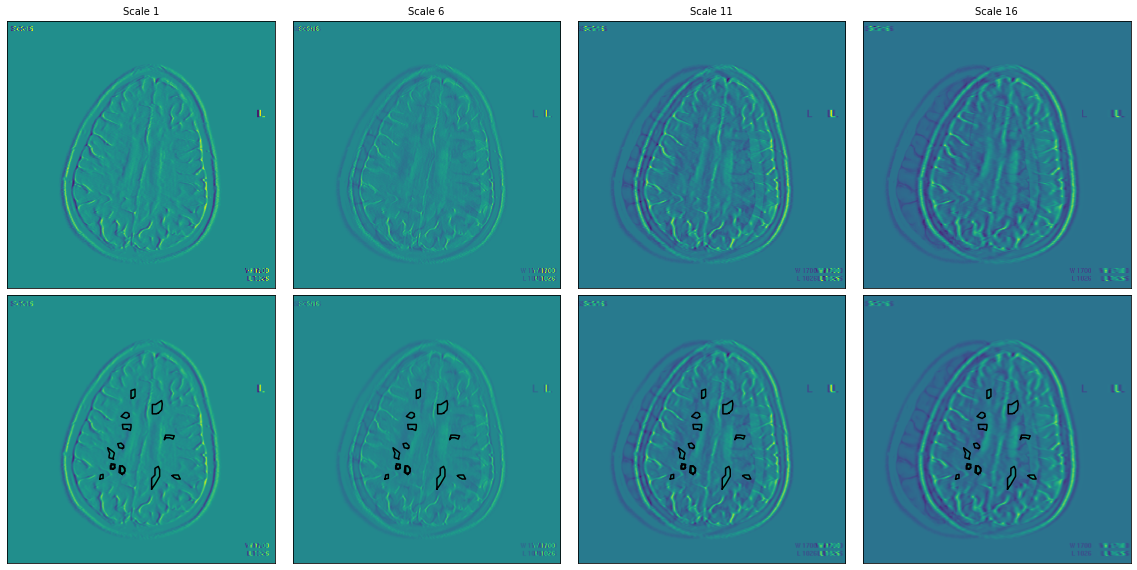


UPSAMPLED IMAGE:

Upsampled shape:  (1024, 1024) Original type:  <class 'numpy.uint8'>


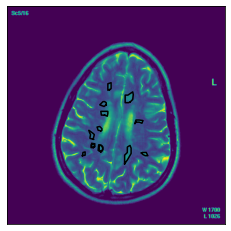

Newimg:  (1024, 1024)

 BIOR6.8 DISCRETE TRANSFORM

Plaque files for image:  ['./MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_1.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_2.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_3.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_4.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_5.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_6.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_7.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_8.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_9.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_10.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_11.plq', './MRIFreeDataset/Initial & r

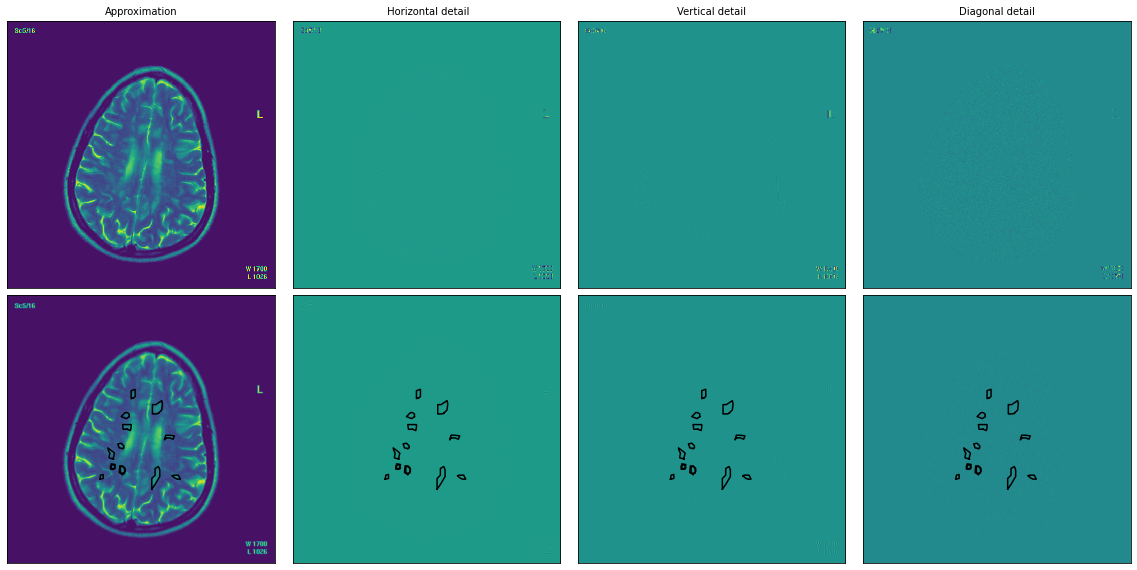


 HAAR DISCRETE TRANSFORM

Plaque files for image:  ['./MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_1.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_2.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_3.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_4.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_5.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_6.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_7.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_8.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_9.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_10.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_11.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Data

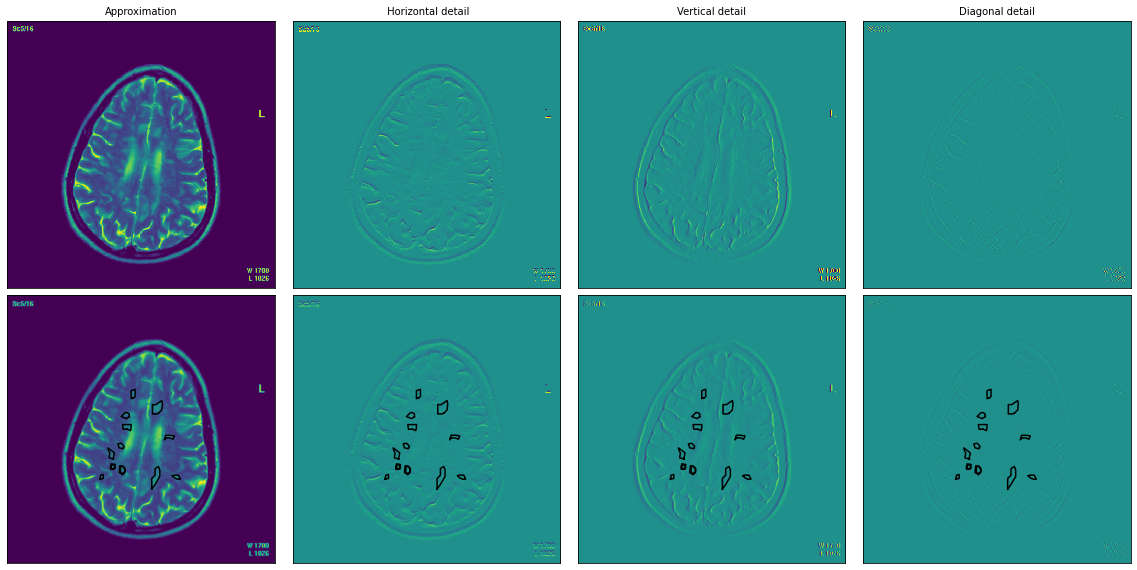


 RBIO4.4 DISCRETE TRANSFORM

Plaque files for image:  ['./MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_1.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_2.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_3.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_4.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_5.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_6.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_7.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_8.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_9.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_10.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_11.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free D

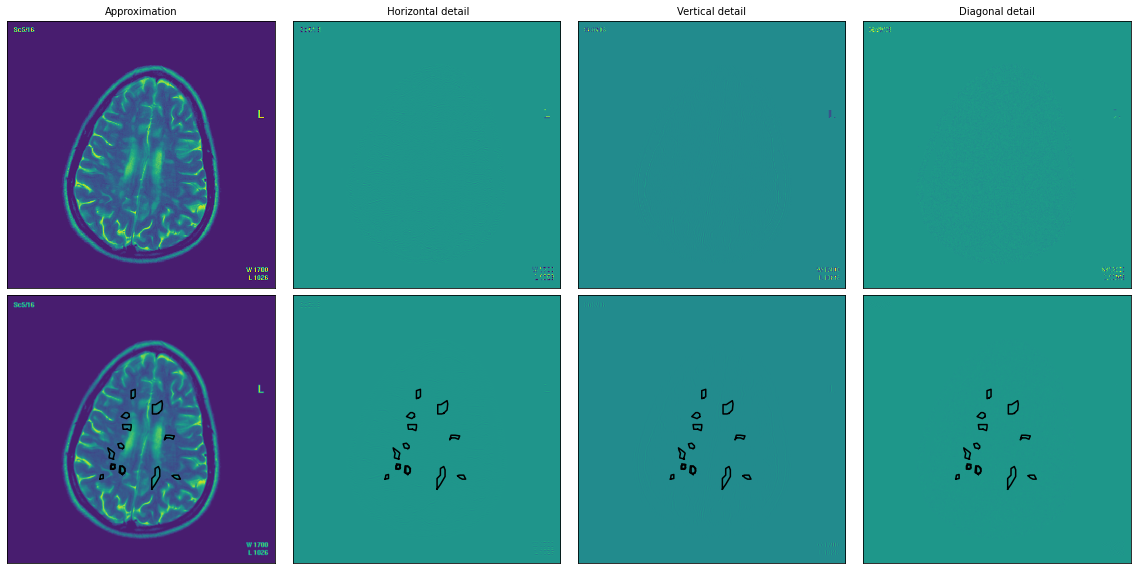


 SYM12 DISCRETE TRANSFORM

Plaque files for image:  ['./MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_1.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_2.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_3.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_4.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_5.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_6.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_7.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_8.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_9.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_10.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dataset/PRI/1/IM_00016_11.plq', './MRIFreeDataset/Initial & repeat MRI in MS-Free Dat

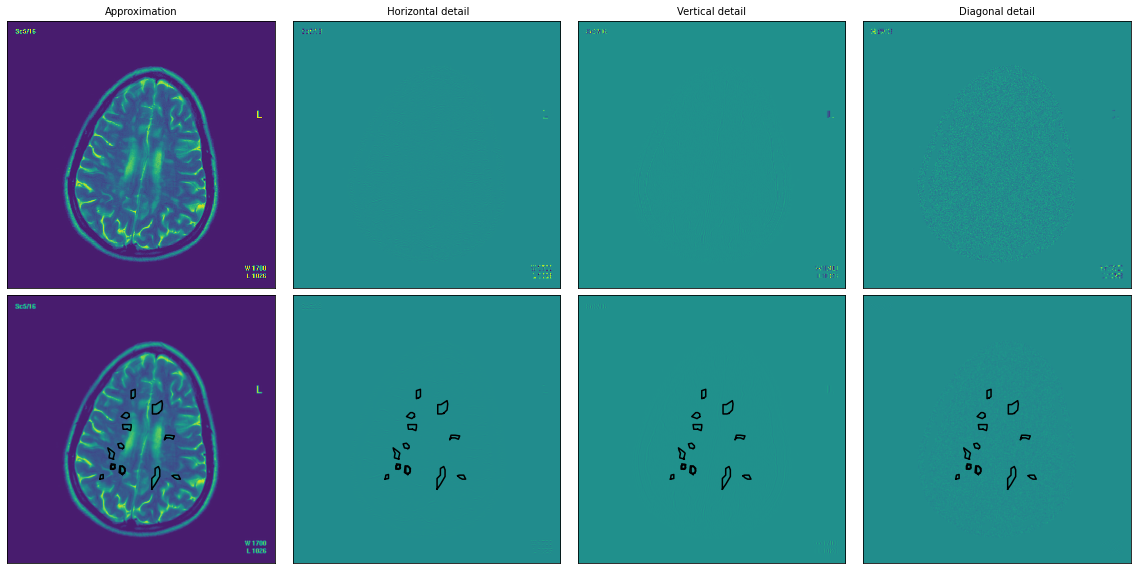

In [ ]:
# Wavelet Transforms
dwtlist = ["bior6.8", "haar", "rbio4.4", "sym12"]
cwtlist = ["mexh", "fbsp", "cgau4", "cgau8", "morl", "gaus4", "cmor"]
cwtscales = [np.arange(1,8,2), np.arange(1,20,6), np.arange(10,24,4), np.arange(10,27,5), np.arange(15,35,6), np.arange(1,17,5), np.arange(1,17,5)]

# Plot unhealthy image + wavelet transforms
msw.plot_transforms(wtlist=cwtlist, type="continuous", cwtscales=cwtscales, imgname=msw.unhealthy_images[100])
msw.plot_transforms(wtlist=dwtlist, type="discrete", imgname=msw.unhealthy_images[100])